# **Задание 1. A/B–тестирование**

### **Условие**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### **Входные данные**

В качестве входных данных Вы имеете 4 csv-файла:
* [groups.csv](https://disk.yandex.ru/d/58Us0DWOzuWAjg) - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* [groups_add.csv](https://disk.yandex.ru/d/3aARY-P9pfaksg) - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* [active_studs.csv](https://disk.yandex.ru/d/prbgU-rZpiXVYg) - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* [checks.csv](https://disk.yandex.ru/d/84hTmELphW2sqQ) - файл с информацией об оплатах пользователей в дни проведения эксперимента.

### **Вопросы**

Предлагаем Вам ответить на следующие вопросы:
* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?
* Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest

from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
pd.options.mode.chained_assignment = None

In [2]:
# Считаем данные
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/58Us0DWOzuWAjg', sep=';')
active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg')
checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ', sep=';')

### **Предподготовка и разведочный анализ данных**

Для начала изучим наш основной файл с информацией о принадлежности к конкретной группе. Посмотрим типы данных. кол-во пропущенных значений. Проверим, являются ли пользователи в наших группах уникальными.

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [6]:
groups.groupby('grp').agg({'id': 'nunique'}).sort_values(by=['id'], ascending=False)

,id
grp,
B,59813
A,14671


Теперь посмотрим на наш файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [7]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [8]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [9]:
active_studs.shape[0]

8341

In [10]:
active_studs.nunique()

student_id    8341
dtype: int64

И наконец на файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [11]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [12]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [13]:
checks.student_id.nunique()

541

Обработаем данные

In [14]:
# Переименуем колонки student_id в id
active_studs.rename(columns={'student_id': 'id'}, inplace=True)
checks.rename(columns={'student_id': 'id'}, inplace=True)

# Добавим метку для активных студентов
active_studs['active'] = 1

In [15]:
full_data = pd.merge(groups, active_studs, how='left')
full_data = pd.merge(full_data, checks, how='left')
full_data.head()

,id,grp,active,rev
0,1489,B,NaN,NaN
1,1627,A,1.0,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN


In [16]:
# Заполним пустые значения нулями
full_data = full_data.fillna(0)
full_data.head()

,id,grp,active,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


Создадим итоговые группы из общего датафрейма. отфильтровав лишние значения

In [17]:
group_a = full_data.query('grp == "A" & rev > 0').rev
group_b = full_data.query('grp == "B" & rev > 0').rev

В качестве метрик возьмем
* средний чек и медианный чек (для доп. проверки)
* CR - конверсию в покупку

1. Начнем с чеков. Посмотрим на распределение наших групп

<AxesSubplot:xlabel='rev', ylabel='Count'>

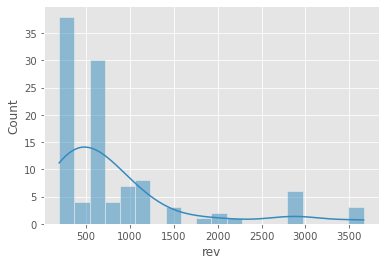

In [18]:
sns.histplot(group_a, bins=20, kde=True)

<AxesSubplot:xlabel='rev', ylabel='Count'>

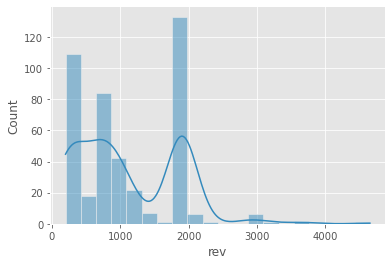

In [19]:
sns.histplot(group_b, bins=20, kde=True)

Проверим среднее и медианное значения в контрольной и тестовой группе

In [20]:
print('Среднее значение в контрольной группе = ', group_a.mean()) 
print('Среднее значение в тестовой группе = ', group_b.mean()) 

Среднее значение в контрольной группе =  860.7102803738318
Среднее значение в тестовой группе =  1106.997698845266


In [21]:
print('Медианное значение в контрольной группе = ', group_a.median()) 
print('Медианное значение в тестовой группе = ', group_b.median()) 

Медианное значение в контрольной группе =  690.0
Медианное значение в тестовой группе =  880.0


Как видим, в тествой группе значения выше. Остается понять насколько это статистически значимо. 

* $H_0$ (Нулевая гипотеза) - статистически значимых различий нет
* $H_1$ (Альтернативная гипотеза) - есть статистически значимые различия

Так как наши распределения не являются нормальными, думаю лучше всего подойдет bootstrap-анализ. Проведем анализ по средним значениям и затем для сравнения по медианным

In [22]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000,
    statistic=np.mean,
    bootstrap_conf_level=0.95
):

    '''
    Функция бутстрап-анализа

    Аргументы функции: 
            data_column_1 - числовые значения первой выборки,
            data_column_2 - числовые значения второй выборки,
            boot_it - количество бутстрэп-подвыборок,
            statistic - интересующая нас статистика,
            bootstrap_conf_level - уровень значимости
            
    Функция работает следующим образом:
            -берутся подвыборки из двух выборок
            -в каждой подвыборке рассчитывается статистика
            -в boot_data добавляется среднее разности значений подвыборок первой и второй группы
            -далее рассчитывается и возвращается доверительный интревал, p-value и строится график
    '''

    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

100%|██████████| 1000/1000 [00:00<00:00, 3019.73it/s]


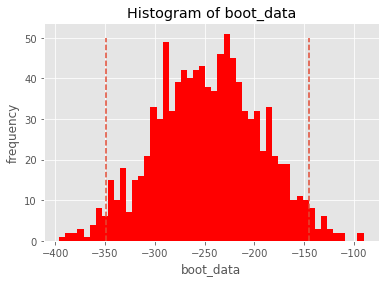

In [23]:
booted_data_mean = get_bootstrap(group_a, group_b, boot_it=1000)

In [24]:
booted_data_mean['p_value']

3.1900935528612776e-06

Как видим в обоих тестах p-value меньше порогового уровня значения в 0.05. Следовательно, средний чек статистически значимо вырос

2. Теперь посмотрим на конверсию в покупку

In [28]:
# Отфильтруем только активных пользователей с помощью добавленной нами метки
active_users = full_data.query('active == 1')
active_users

,id,grp,active,rev
1,1627,A,1.0,990.0
10,2085,B,1.0,0.0
12,2215,B,1.0,0.0
43,3391,A,1.0,0.0
45,3401,B,1.0,0.0
...,...,...,...,...
74452,5681918,B,1.0,1900.0
74456,5685258,B,1.0,0.0
74461,5688310,B,1.0,0.0
74464,5689627,B,1.0,0.0


Добавим в датафрейм колонку, отражающую факт покупки
* 1 - покупка была совершена
* 0 - не была совершена

In [29]:
active_users['purchase'] = active_users.rev.apply(lambda x: 1 if x != 0 else 0)
active_users.head()

,id,grp,active,rev,purchase
1,1627,A,1.0,990.0,1
10,2085,B,1.0,0.0,0
12,2215,B,1.0,0.0,0
43,3391,A,1.0,0.0,0
45,3401,B,1.0,0.0,0


In [30]:
# Рассчитаем конверсию
cr_table = pd.crosstab(active_users.grp, active_users.purchase)
cr_table[1] / cr_table[0]

grp
A    0.053535
B    0.048302
dtype: float64

Поскольку здесь мы имеем дело с двумя номинативными переменными, в данном случае для стат. анализа нам подойдут
* z тест пропорций 
* хи квадрат Пирсона

Гипотезы для проверки

* $H_0$ (Нулевая гипотеза) - статистически значимых различий нет
* $H_1$ (Альтернативная гипотеза) - есть статистически значимые различия

In [31]:
def prop_ztest(table):
    
    '''
    Функция z-test
    '''

    count = np.array(table[1])
    nobs = np.array(table[0])
    stat, p_value = proportions_ztest(count, nobs)
    
    return p_value

In [32]:
prop_ztest(cr_table)

0.4043716223592251

In [33]:
# Хи квадрат Пирсона
stat, p_value, dof, expected = st.chi2_contingency(cr_table)

prob = 0.95
critical = st.chi2.ppf(prob, dof)

stat > critical, p_value

(False, 0.46803677583199144)

По итогу этих двух тестов, мы не можем отклонить нулевую гипотезу, о том что статистически значимых различий между группами нет

## **Итоговые выводы**

В результате проведенных экспериментов мы видим:
1. средний чек в тестовой группе статистически значимо вырос
2. при этом конверсия в покупку статистически значимо не уизменилась

Считаю, что мы можем смело выкатывать наше обновление на всех пользователей, так как в тестовой группе чек. а соответвенно и доход значительно выросли и нам удалось сохранить уровень конверсии на хорошем уровне, пусть и без сильного увеличения.

==============================================================================================

# **Задание 2. SQL**

Все данные находятся в табличном виде в Clickhouse

## **2.1 Очень усердные ученики.**

### **Условие**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

### **Задача**

Дана таблица **peas**:

```
Название атрибута   Тип атрибута    Смысловое значение

st_id	            int	ID          ученика
timest	            timestamp       Время решения карточки
correct	            bool            Правильно ли решена горошина?
subject	            text            Дисциплина, в которой находится горошина
```

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

### **Решение**

```sql
SELECT
    COUNT(DISTINCT st_id)
FROM
    (
    SELECT 
        st_id,
        toDayOfMonth(timest) AS month_day,
        toHour(timest) AS hour 
        SUM(correct) AS correct_count
    FROM
        peas
    WHERE
        toStartOfMonth(timest) = '2020-03-01'
    GROUP BY 
        st_id,
        toDayOfMonth(timest),
        toHour(timest)
    )
WHERE
    correct_count >= 20
```

==============================================================================================

## **2.2 Оптимизация воронки**

### **Условие**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### **Задача**

Дана таблицы: **peas** (см. выше), **studs**:

```
Название атрибута   Тип атрибута    Смысловое значение

st_id	            int             ID ученика
test_grp            text            Метка ученика в данном эксперименте
```

и **final_project_check**:

```
Название атрибута   Тип атрибута    Смысловое значение

st_id               int             ID ученика
sale_time           datatime        Время покупки
money               int             Цена, по которой приобрели данный курс
subject             text            Дисциплина, на которую приобрели полный доступ
```

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

### **Решение**

```sql
SELECT
    test_grp,
    SUM(money) / COUNT(s.st_id) AS ARPU,
    SUM(money) / COUNT(p.st_id) AS ARPAU,
    COUNT(c.st_id) / COUNT(p.st_id) AS CR,
    COUNT(c.st_id) / COUNT(p.st_id) AS CR_active,
    SUM(CASE WHEN subject = ’Math’ THEN 1 ELSE 0 END) / SUM(CASE WHEN b.st_id IS NOT NULL THEN 1 ELSE 0 END) AS CR_active_math
FROM
    peas AS p 
LEFT JOIN final_project_check AS c
    ON p.st_id = c.st_id
LEFT JOIN (
            SELECT
               DISTINCT st_id
	        FROM 
	            peas
	        WHERE
                subject = ’Math’
	    ) AS b
    ON p.st_id = b.st_id
JOIN studs AS s
    ON p.st_id = s.st_id
GROUP BY
    test_grp
```

==============================================================================================

## **Задание 3. Python**

### **Задача**

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Добавим файл, который отправили спустя два дня и проверим его

In [34]:
groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3aARY-P9pfaksg', sep=',')
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [35]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [36]:
groups_add.id.nunique()

92

Построим требуемую функцию

In [37]:
# функция добавления новых данных, обработки и пересчитывания метрик
def add_data(groups, active_studs, checks):
    
    # формируем датафрейм  
    groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3aARY-P9pfaksg', sep=',')
    groups = groups.append(groups_add)

    # переименовываем колонки
    active_studs.rename(columns={'student_id': 'id'}, inplace=True)
    checks.rename(columns={'student_id': 'id'}, inplace=True)

    # добавляем метку для активных студентов
    active_studs['active'] = 1
    
    # объединяем датафреймы
    all_data = pd.merge(groups, active_studs, how='left')
    all_data = pd.merge(all_data, checks, how='left')
    all_data = all_data.fillna(0)
    
    cr_table = pd.crosstab(active_users.grp, active_users.purchase)

    # пересчитываем метрики
    avg_check = pd.DataFrame(
        {'grp': ['A', 'B'], 'avg_check': [round(all_data.query('grp == "A" & rev > 0').rev.mean(), 2),
                                          round(all_data.query('grp == "B" & rev > 0').rev.mean(), 2)]})
                                            
    conversion = pd.DataFrame(cr_table[1] / cr_table[0]) \
                   .reset_index() \
                   .rename(columns={0: 'cr'})

    return {'avg_check': avg_check,
            'conversion': conversion}

In [38]:
metrics = add_data(groups, checks, active_studs)

In [39]:
metrics['avg_check']

,grp,avg_check
0,A,860.71
1,B,1108.82


In [40]:
metrics['conversion']

,grp,cr
0,A,0.053535
1,B,0.048302


Теперь напишем функцию для визуализации наших метрик

In [41]:
# функция для визуализации полученных метрик
def get_plots(metrics):
    
    plt.figure(figsize=(16, 7))

    # график среднего чека
    plt.subplot(1, 2, 1)
    bar = sns.barplot(x='grp', y='avg_check', data=metrics['avg_check'])
    bar.axes.set_title('Средний чек', fontsize=16)
    bar.set_xlabel('Группа', fontsize=12)
    bar.set_ylabel('Доход', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # график конверсии
    plt.subplot(1, 2, 2)
    bar = sns.barplot(x='grp', y='cr', data=metrics['conversion'])
    bar.axes.set_title("Конверсия", fontsize=16)
    bar.set_xlabel('Группы', fontsize=12)
    bar.set_ylabel('CR в процентах', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

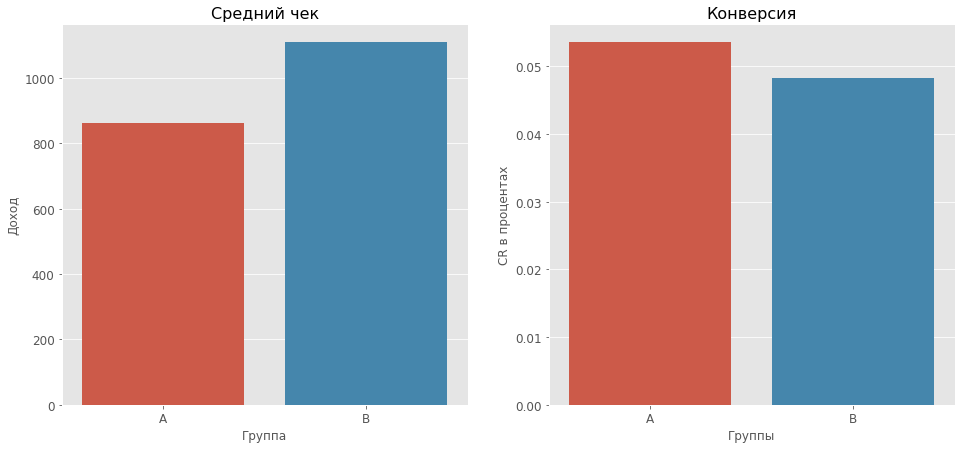

In [42]:
get_plots(metrics)